In [2]:
from mylib.statistic_test import *

code_id = "0853 - Diverge of Route 7 Map"
loc = os.path.join(figpath, code_id)
mkdir(loc)

from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

dir_name1 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")
dir_name0 = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def get_transient_map(mouse: int):
    """
    Get Final Maps and Information
    """
    if exists(join(dir_name1, f"transient_{mouse}.pkl")):
        with open(join(dir_name1, f"transient_{mouse}.pkl"), "rb") as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError(
            f"Please run Fig0850 - Lisa Paper Revisits.ipynb first "
            f"to generate transient_{mouse}.pkl"
        )

def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])
MAPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in ['#333766', '#A4C096']])

from umap.umap_ import UMAP
from matplotlib import cm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN, KMeans
import hdbscan

def counts(mouse: int):
    with open(join(dir_name0, f"{mouse}.pkl"), 'rb') as handle:
        _, session_traj, _, _, route_traj, lap_traj, pos_traj, speed_traj, _, _, _, _, _, neural_traj = pickle.load(handle)

    bins = np.concatenate([Father2SonGraph[i] for i in np.setdiff1d(CP_DSP[6], CP_DSP[3])])
    idx = np.where(
        (np.isin(pos_traj, bins-1)) &
        (np.isin(route_traj, [0, 1, 2, 4, 5, 6]))
    )[0]
    
    D = GetDMatrices(1, 48)
    dist_traj = D[pos_traj, 2303]
    
    with open(join(loc, f"{mouse}.pkl"), "wb") as f:
        pickle.dump([
            neural_traj[:, idx], 
            session_traj[idx], 
            route_traj[idx], 
            lap_traj[idx], 
            pos_traj[idx], 
            speed_traj[idx]
        ], f)

def get_data(mouse):
    """All Data"""
    if exists(join(loc, f"{mouse}.pkl")) == False:
        counts(mouse)
        
    with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
        return pickle.load(handle)

        E:\Data\FinalResults\0853 - Diverge of Route 7 Map is already existed!


<Axes: >

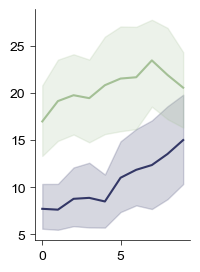

In [28]:
def get_fate(mouse: int):
    (
        kmeans_dist_traj2, 
        neural_traj2, 
        session_traj2, 
        old_pos_traj2, 
        route_traj2, 
        lap_traj2, 
        pos_traj2, 
        speed_traj2,
        dists
    ) = get_transient_map(mouse)
    
    beg2 = np.concatenate([[0], np.where(np.ediff1d(lap_traj2) != 0)[0]+1])
    end2 = np.concatenate([np.where(np.ediff1d(lap_traj2) != 0)[0]+1, [lap_traj2.shape[0]]])
    
    mat = np.corrcoef(neural_traj2[:, beg2].T)
    avg_mat = np.zeros((7, 7))
    for i in range(7):
        for j in range(i, 7):
            idxi = np.where(route_traj2[beg2] == i)[0]
            idxj = np.where(route_traj2[beg2] == j)[0]
            idx = np.ix_(idxi, idxj)
            avg_mat[i, j] = avg_mat[j, i] = np.nanmean(mat[idx])
    
    idx = np.where(route_traj2[beg2] != 3)[0]
    beg2 = beg2[idx]
    end2 = end2[idx]

    median_kmean_dists = np.zeros(beg2.shape[0])
    for i in range(beg2.shape[0]):
        median_kmean_dists[i] = np.nanmean(kmeans_dist_traj2[beg2[i]:end2[i]])

    labels = np.where(median_kmean_dists > 0, 0, 1)    
    return median_kmean_dists, labels

mouse = 10227
(            
    neural_traj,
    session_traj,  
    route_traj, 
    lap_traj, 
    pos_traj, 
    speed_traj
) = get_data(mouse)

beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [lap_traj.shape[0]]])
mean_kmean_dists, lap_labels = get_fate(mouse)

route7_idx = np.where(route_traj[beg] == 6)[0]
durations = (end[route7_idx] - beg[route7_idx]) / 10

fig, ax = plt.subplots(figsize=(2, 3))
ax = Clear_Axes(axes=ax, close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
x, y, hue = [], [], []
for i, idx in enumerate(route7_idx):
    x.append(np.arange(10))
    y.append(speed_traj[beg[idx]:beg[idx]+10])
    hue.append(np.repeat(lap_labels[idx], 10))

x = np.concatenate(x)
y = np.concatenate(y)
hue = np.concatenate(hue)
sns.lineplot(x=x, y=y, hue=hue, ax=ax, palette=['#333766', '#A4C096'], legend=False)

# Behavioral Differences

In [23]:
from mylib.statistic_test import *

code_id = "0853 - Diverge of Route 7 Map"
loc = os.path.join(figpath, code_id)
mkdir(loc)

if exists(join(figdata, f"{code_id} [Lap Info].pkl")) == False:
    EffData = {
        "MiceID": [],
        "Session": [],
        "Is Perfect": [],
        "Lapwise Time": [],
        "Lapwise Distance": [],
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")) == False:
            X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
            
            with open(join(loc, f"{mouse}.pkl"), "wb") as f:
                pickle.dump([X, session_label, route_label, kmeans_init], f)
        else:
            with open(join(loc, f"{mouse}.pkl"), "rb") as f:
                X, session_label, route_label, kmeans_init = pickle.load(f)



        E:\Data\FinalResults\0853 - Diverge of Route 7 Map is already existed!
